In [126]:
import sys
sys.path.append('..')
sys.path.append('../src')
sys.path.append('../data')

import torch
import plotly.express as px
import src.nanda_plot
from src.nanda_plot import imshow_reversed, imshow
import pandas as pd
import numpy as np

from src.result_analyzer import ResultAnalyzer

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate the CSV file

In [130]:
result = ResultAnalyzer("ablation_gpt2_full_result.pt")

In [131]:
result.data["cp"]["premise"] = [el for x in result.data["cp"]["premise"] for el in x]
result.data["mem"]["premise"] = [el for x in result.data["mem"]["premise"] for el in x]
result.process_pos_top_component_per_prompt()
result.process_neg_top_component_per_prompt()
result.process_pos_attn_head_out()
result.process_neg_attn_head_out()
result.process_pos_component_out_by_pos("mlp_out")
result.process_pos_component_out_by_pos("attn_out_by_pos")
result.process_neg_component_out_by_pos("mlp_out")
result.process_neg_component_out_by_pos("attn_out_by_pos")

,id,mean,std,t-test,p-value,kl-mean,kl-std
0,L0P0,0.157587,0.037667,8.367296,0.003580,0.000013,0.000039
1,L0P1,-0.027829,0.107623,-0.517162,0.640755,-0.000066,0.000021
2,L0P2,-0.058110,0.021977,-5.288211,0.013191,-0.000047,0.000004
3,L0P3,-0.064244,0.088855,-1.446036,0.243944,-0.000052,0.000106
4,L0P4,-0.027143,0.128354,-0.422946,0.700822,0.000040,0.000052
...,...,...,...,...,...,...,...
175,L11P10,0.000000,0.000000,NaN,NaN,0.000000,0.000000
176,L11P11,0.000000,0.000000,NaN,NaN,0.000000,0.000000
177,L11P12,0.000000,0.000000,NaN,NaN,0.000000,0.000000
178,L11P13,0.000000,0.000000,NaN,NaN,0.000000,0.000000


## PLOT

In [133]:
import pandas as pd
FILE_NAME = "ablation_gpt2_full_result"
# Load a sample from each CSV file to understand their structure
csv_files = [
    f"{FILE_NAME}_cp_attn_head_out.csv",
    f"{FILE_NAME}_cp_attn_out_by_pos.csv",
    f"{FILE_NAME}_cp_mlp_out.csv",
    f"{FILE_NAME}_mem_attn_head_out.csv",
    f"{FILE_NAME}_mem_attn_out_by_pos.csv",
    f"{FILE_NAME}_mem_mlp_out.csv",
]

sample_data = {}

for file in csv_files:
    sample_data[file] = pd.read_csv(f'../results/locate_mechanism/ablation/{file}').head()

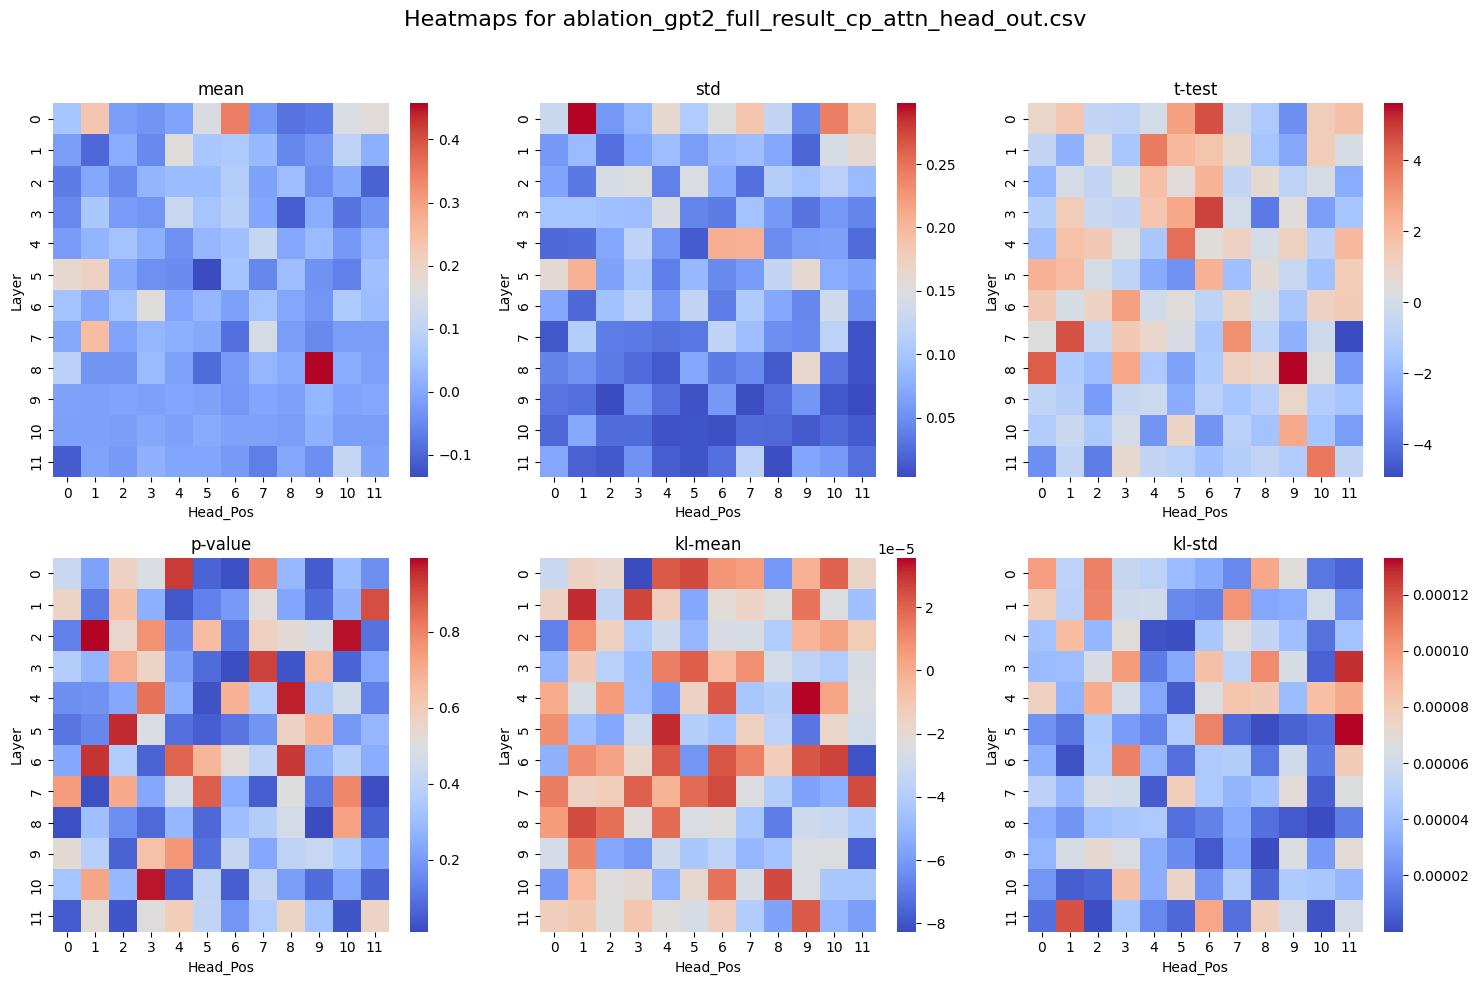

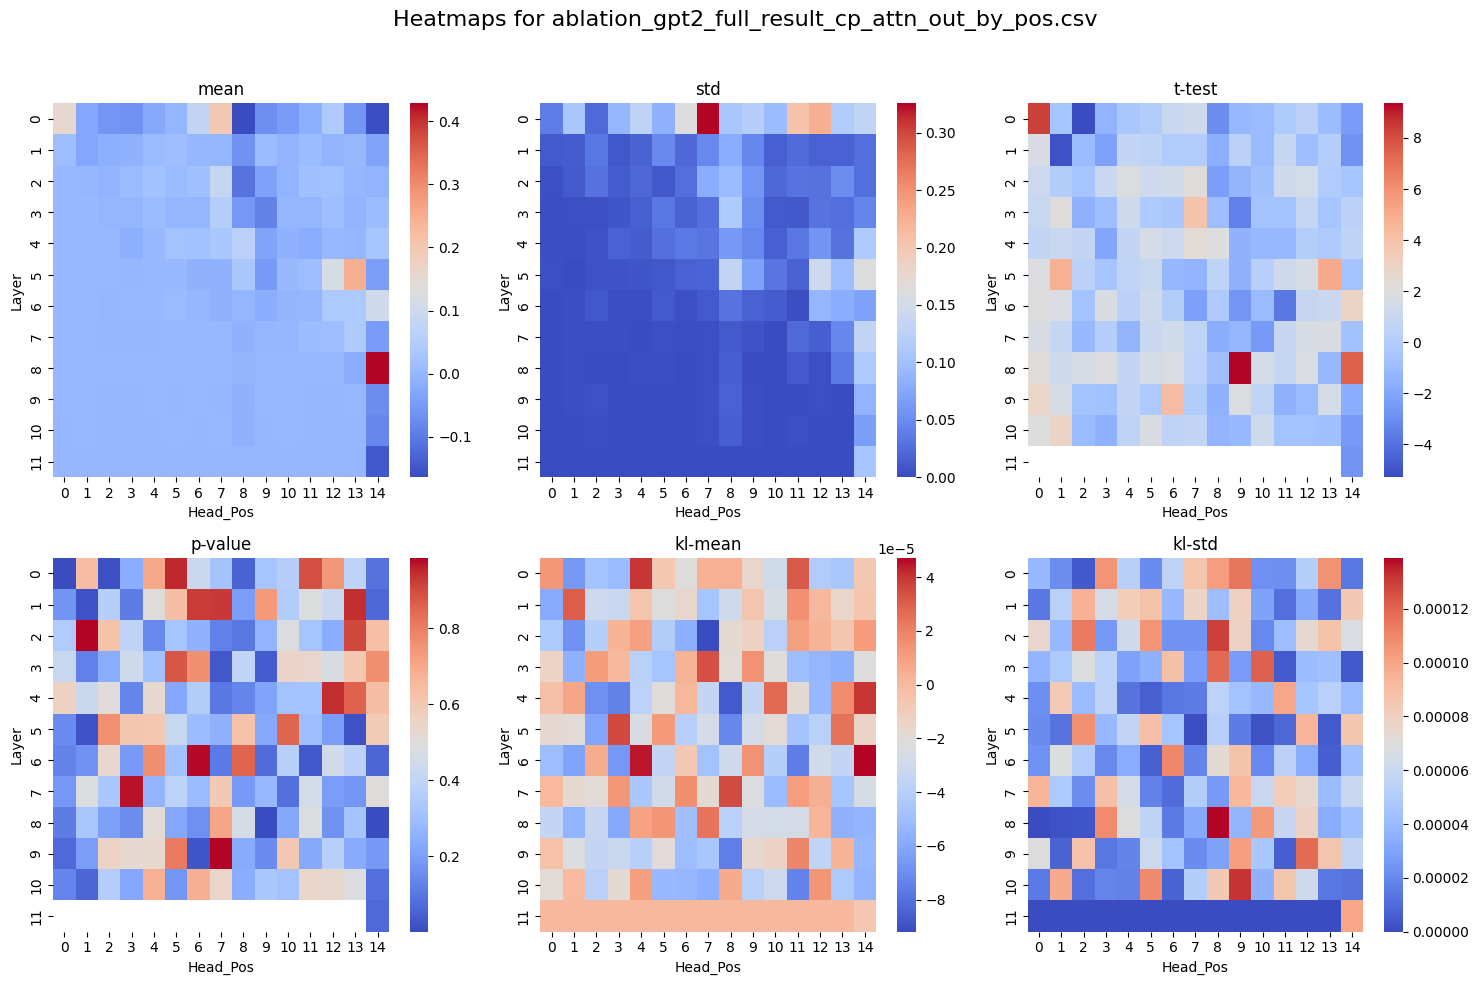

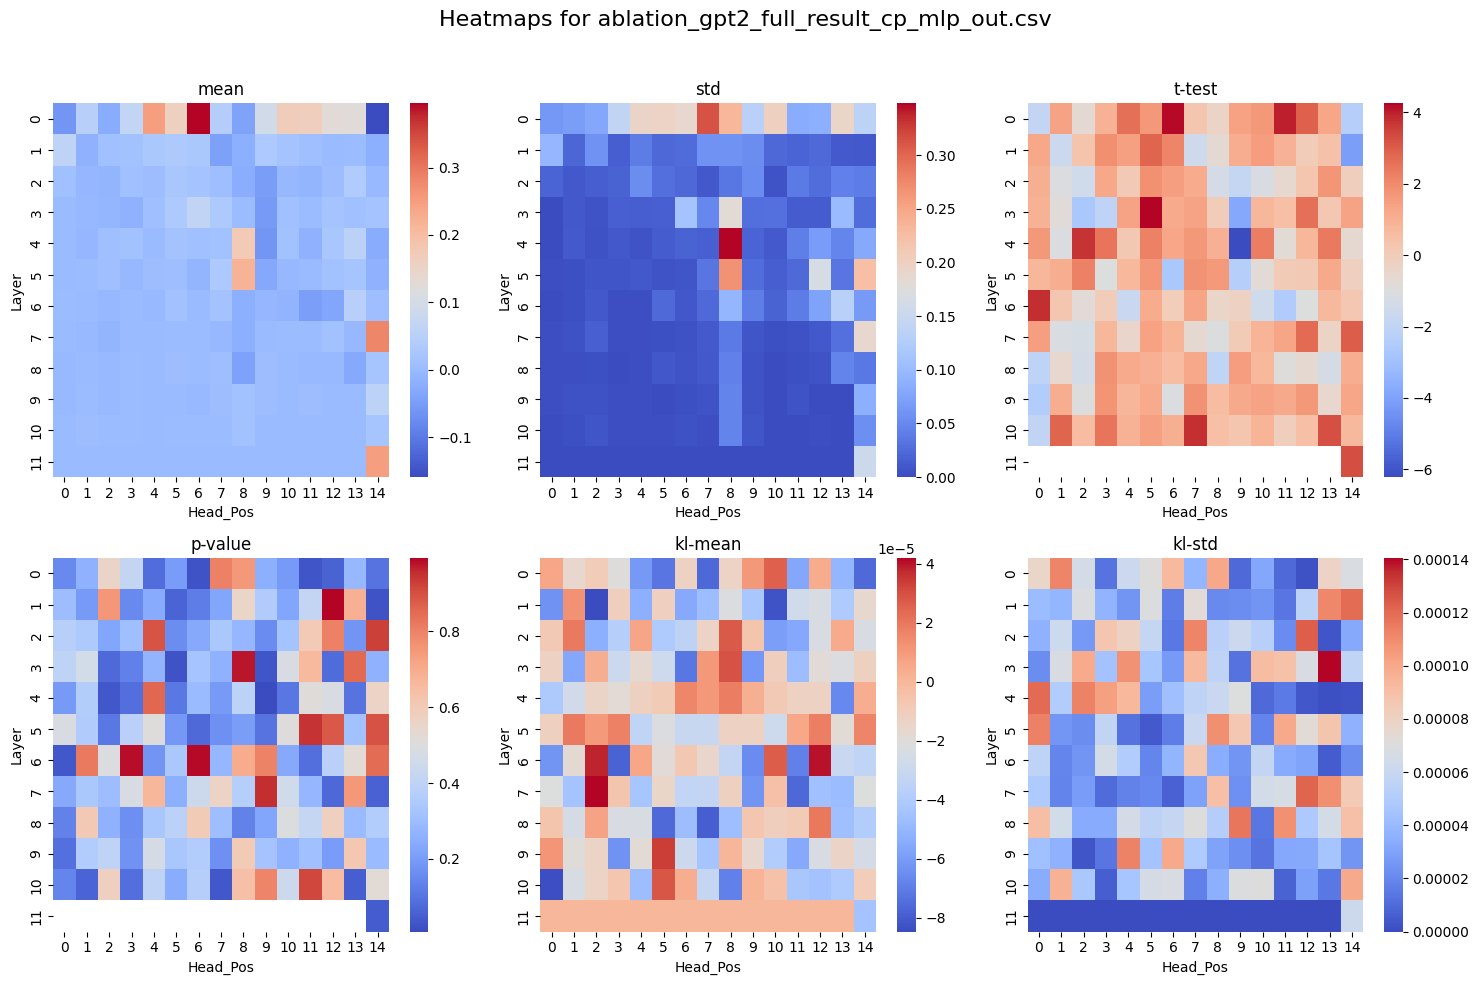

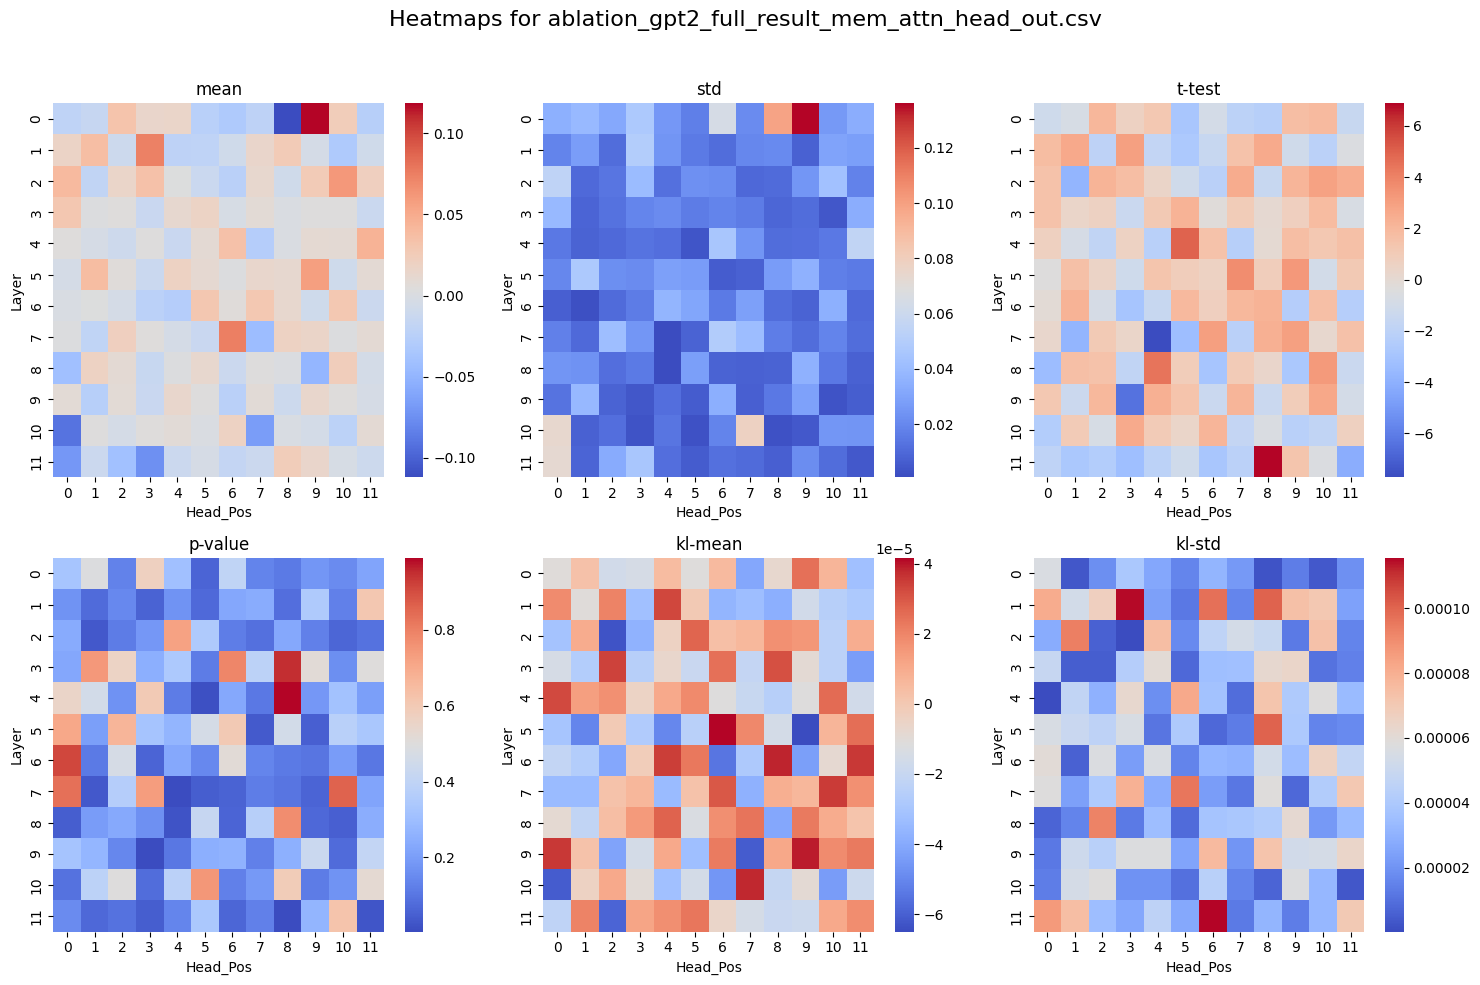

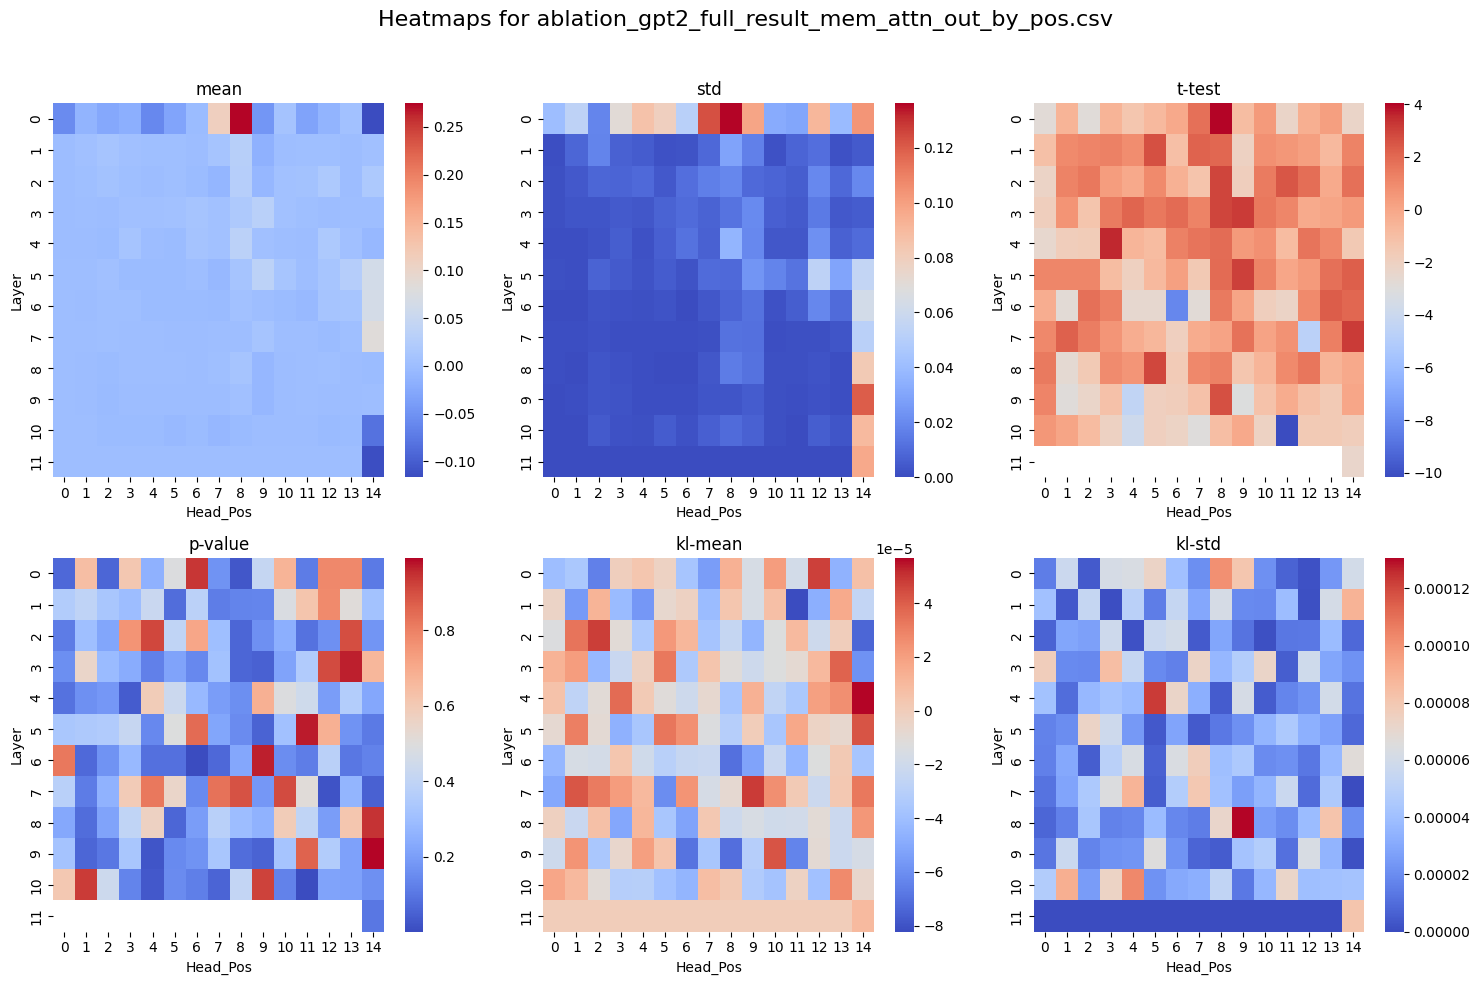

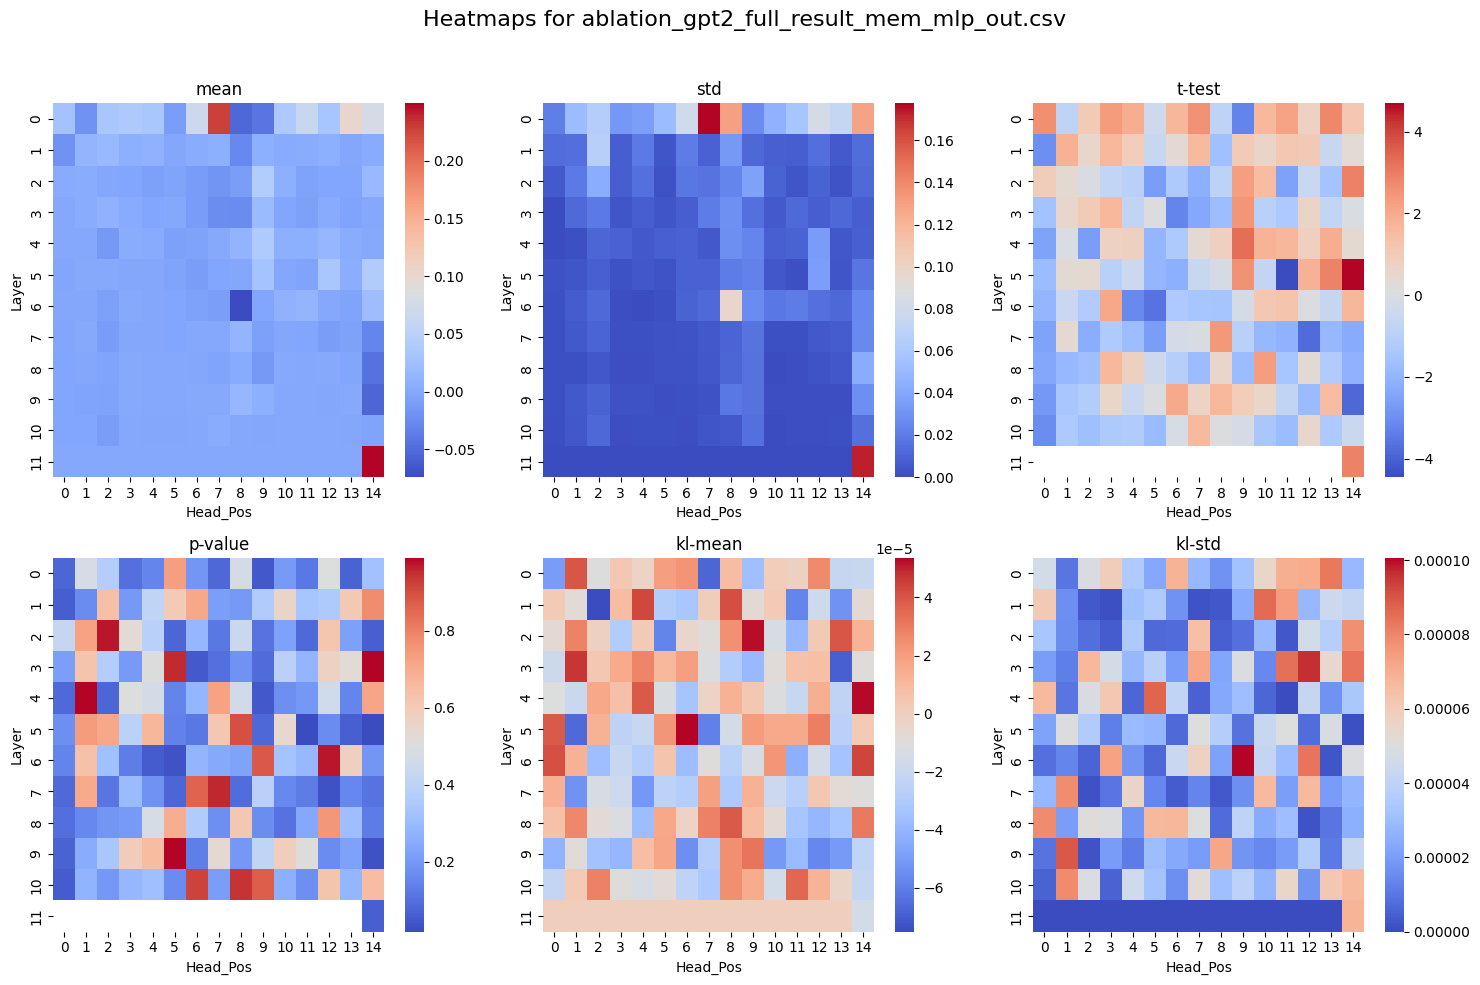

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Function to plot heatmaps for each file
def plot_heatmaps(file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    df['Layer'] = df['id'].apply(lambda x: int(x.split('L')[1].split('H')[0].split('P')[0]))
    df['Head_Pos'] = df['id'].apply(lambda x: int(x.split('H')[-1]) if 'H' in x else int(x.split('P')[-1]))
    
    df = df.sort_values(by=['Layer', 'Head_Pos'])

    # Create a 3x3 grid of subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f"Heatmaps for {os.path.basename(file_path)}", fontsize=16)
    
    # List of columns to plot
    columns_to_plot = ['mean', 'std', 't-test', 'p-value', 'kl-mean', 'kl-std']
    
    for idx, col in enumerate(columns_to_plot):
        ax = axes.flatten()[idx]
        
        # Create a pivot table for the heatmap
        pivot_df = df.pivot(index='Layer', columns='Head_Pos', values=col)

        
        # Plot the heatmap
        sns.heatmap(pivot_df, cmap='coolwarm', ax=ax, annot=False, fmt=".2f")
        ax.set_title(col)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot heatmaps for each uploaded file
for file_name in csv_files:
    file_path = os.path.join("../results/locate_mechanism/", file_name)
    plot_heatmaps(file_path)


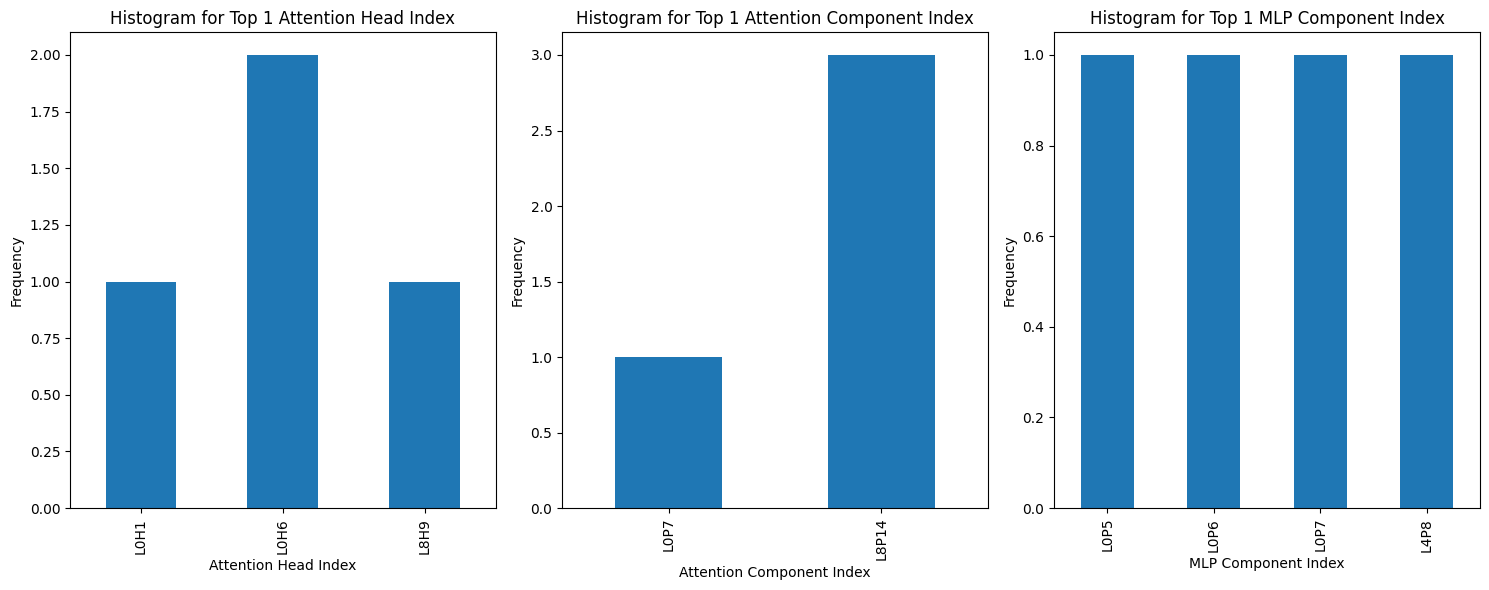

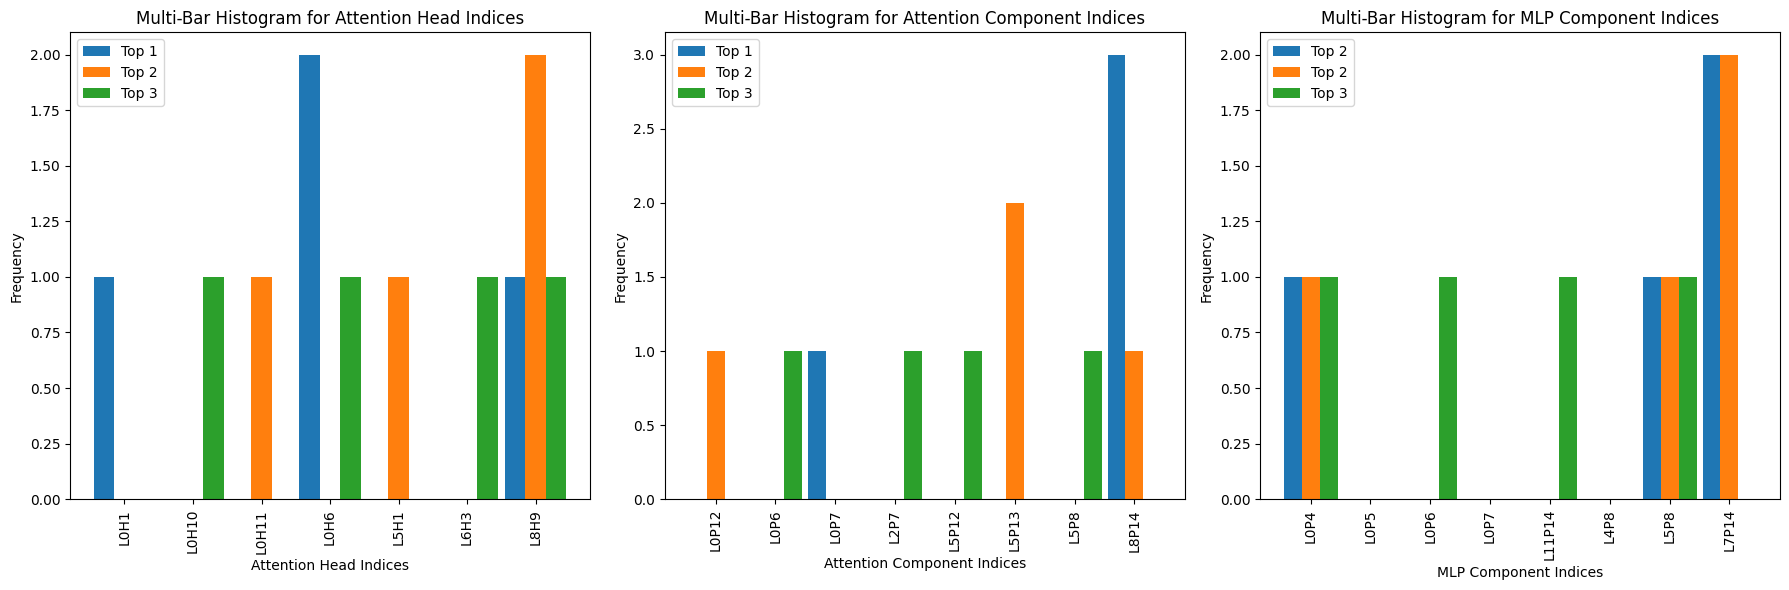

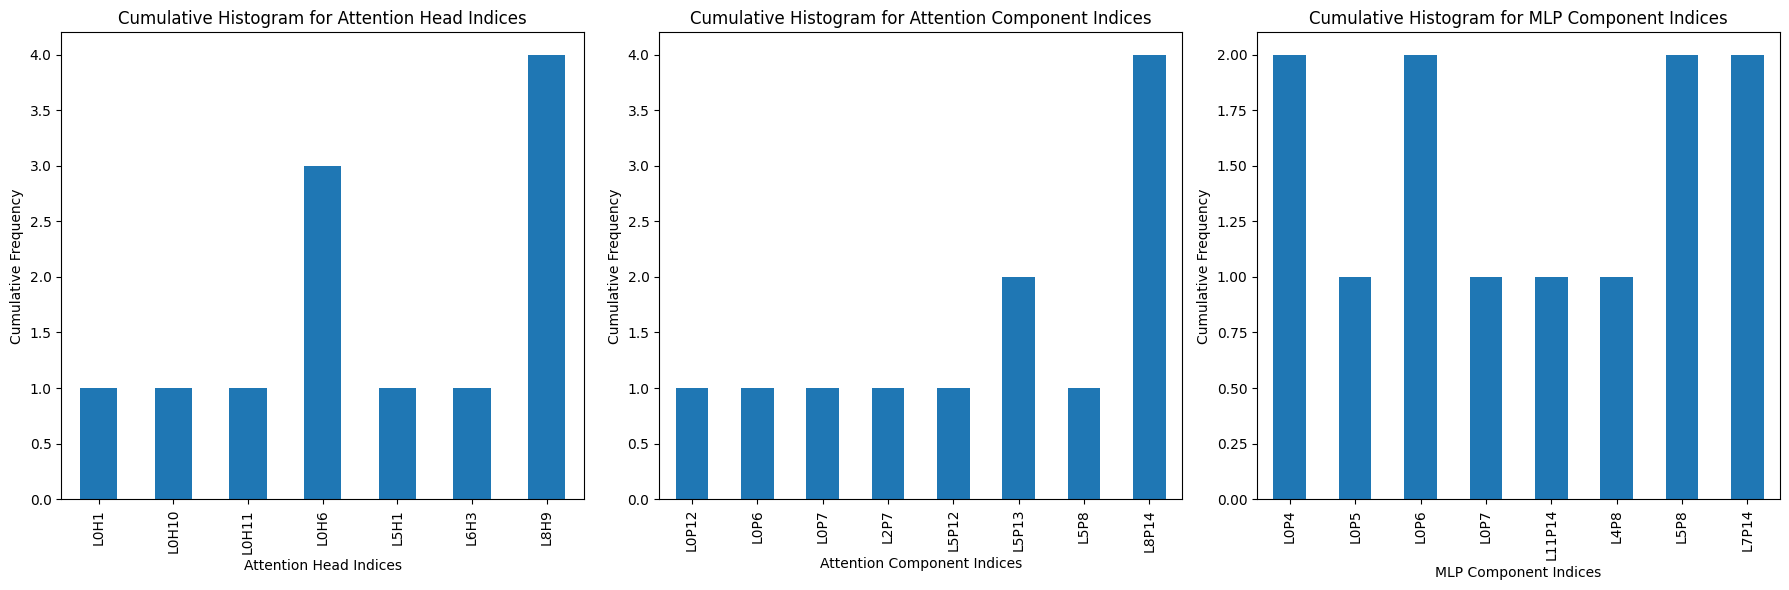

In [136]:
import numpy as np

df = pd.read_csv(f"../results/locate_mechanism/ablation/{FILE_NAME}_cp_top_component_per_prompt.csv")

import matplotlib.pyplot as plt

# Create histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Histogram for top1_attention_head_idx
df['top1_attention_head_idx'].value_counts().sort_index().plot(kind='bar', ax=axes[0])
axes[0].set_title('Histogram for Top 1 Attention Head Index')
axes[0].set_xlabel('Attention Head Index')
axes[0].set_ylabel('Frequency')

df["top1_component_attn_idx"].value_counts().sort_index().plot(kind='bar', ax=axes[1])
axes[1].set_title('Histogram for Top 1 Attention Component Index')
axes[1].set_xlabel('Attention Component Index')
axes[1].set_ylabel('Frequency')

# Histogram for top1_component_mlp_idx
df['top1_component_mlp_idx'].value_counts().sort_index().plot(kind='bar', ax=axes[2])
axes[2].set_title('Histogram for Top 1 MLP Component Index')
axes[2].set_xlabel('MLP Component Index')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Combine the top 3 indices for attention heads and MLP components
top3_attention_head_indices = pd.concat([df['top1_attention_head_idx'], df['top2_attention_head_idx'], df['top3_attention_head_idx']], axis=0).reset_index(drop=True)
top3_attn_out_indices = pd.concat([df['top1_component_attn_idx'], df['top2_component_attn_idx'], df['top3_component_attn_idx']], axis=0).reset_index(drop=True)
top3_mlp_indices = pd.concat([df['top1_component_mlp_idx'], df['top2_component_mlp_idx'], df['top3_component_mlp_idx']], axis=0).reset_index(drop=True)


# Count the frequencies
attention_head_counts = top3_attention_head_indices.value_counts().sort_index()
attn_out_count = top3_attn_out_indices.value_counts().sort_index()
mlp_counts = top3_mlp_indices.value_counts().sort_index()

# Prepare data for multi-bar histograms
labels = np.unique(top3_attention_head_indices)
top1_attention_counts = df['top1_attention_head_idx'].value_counts().reindex(labels, fill_value=0)
top2_attention_counts = df['top2_attention_head_idx'].value_counts().reindex(labels, fill_value=0)
top3_attention_counts = df['top3_attention_head_idx'].value_counts().reindex(labels, fill_value=0)

labels_attn = np.unique(top3_attn_out_indices)
top1_attn_counts = df['top1_component_attn_idx'].value_counts().reindex(labels_attn, fill_value=0)
top2_attn_counts = df['top2_component_attn_idx'].value_counts().reindex(labels_attn, fill_value=0)
top3_attn_counts = df['top3_component_attn_idx'].value_counts().reindex(labels_attn, fill_value=0)

labels_mlp = np.unique(top3_mlp_indices)
top1_mlp_counts = df['top1_component_mlp_idx'].value_counts().reindex(labels_mlp, fill_value=0)
top2_mlp_counts = df['top2_component_mlp_idx'].value_counts().reindex(labels_mlp, fill_value=0)
top3_mlp_counts = df['top3_component_mlp_idx'].value_counts().reindex(labels_mlp, fill_value=0)

# Create multi-bar histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Attention heads
x = np.arange(len(labels))
width = 0.3
axes[0].bar(x - width, top1_attention_counts, width, label='Top 1')
axes[0].bar(x, top2_attention_counts, width, label='Top 2')
axes[0].bar(x + width, top3_attention_counts, width, label='Top 3')
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels, rotation=90)
axes[0].set_title('Multi-Bar Histogram for Attention Head Indices')
axes[0].set_xlabel('Attention Head Indices')
axes[0].set_ylabel('Frequency')
axes[0].legend()

x_attn = np.arange(len(labels_attn))
axes[1].bar(x_attn - width, top1_attn_counts, width, label='Top 1')
axes[1].bar(x_attn, top2_attn_counts, width, label='Top 2')
axes[1].bar(x_attn + width, top3_attn_counts, width, label='Top 3')
axes[1].set_xticks(x_attn)
axes[1].set_xticklabels(labels_attn, rotation=90)
axes[1].set_title('Multi-Bar Histogram for Attention Component Indices')
axes[1].set_xlabel('Attention Component Indices')
axes[1].set_ylabel('Frequency')
axes[1].legend()


# MLP components
x_mlp = np.arange(len(labels_mlp))
axes[2].bar(x_mlp - width, top2_mlp_counts, width, label='Top 2')
axes[2].bar(x_mlp, top2_mlp_counts, width, label='Top 2')
axes[2].bar(x_mlp + width, top3_mlp_counts, width, label='Top 3')
axes[2].set_xticks(x_mlp)
axes[2].set_xticklabels(labels_mlp, rotation=90)
axes[2].set_title('Multi-Bar Histogram for MLP Component Indices')
axes[2].set_xlabel('MLP Component Indices')
axes[2].set_ylabel('Frequency')
axes[2].legend()

plt.tight_layout()
plt.show()

# Calculate cumulative counts for attention head indices and MLP component indices
cumulative_attention_counts = top1_attention_counts + top2_attention_counts + top3_attention_counts
cumulative_attn_out_counts = top1_attn_counts + top2_attn_counts + top3_attn_counts
cumulative_mlp_counts = top1_mlp_counts + top2_mlp_counts + top3_mlp_counts

# Create cumulative histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Cumulative histogram for attention head indices
cumulative_attention_counts.sort_index().plot(kind='bar', ax=axes[0])
axes[0].set_title('Cumulative Histogram for Attention Head Indices')
axes[0].set_xlabel('Attention Head Indices')
axes[0].set_ylabel('Cumulative Frequency')

cumulative_attn_out_counts.sort_index().plot(kind='bar', ax=axes[1])
axes[1].set_title('Cumulative Histogram for Attention Component Indices')
axes[1].set_xlabel('Attention Component Indices')
axes[1].set_ylabel('Cumulative Frequency')

# Cumulative histogram for MLP component indices
cumulative_mlp_counts.sort_index().plot(kind='bar', ax=axes[2])
axes[2].set_title('Cumulative Histogram for MLP Component Indices')
axes[2].set_xlabel('MLP Component Indices')
axes[2].set_ylabel('Cumulative Frequency')

plt.tight_layout()
plt.show()


In [112]:
LAYER = 8
HEAD = 5

# search
print( "mean:", result.data["cp"]["attn_head_out"]["mean"][0,LAYER,HEAD])
print( "std:", result.data["cp"]["attn_head_out"]["std"][0,LAYER,HEAD])
print( "p-value:", result.data["cp"]["attn_head_out"]["p-value"][0,LAYER,HEAD])

mean: tensor(0.0230)
std: tensor(0.0382)
p-value: tensor(3.1890e-08)


## MEM

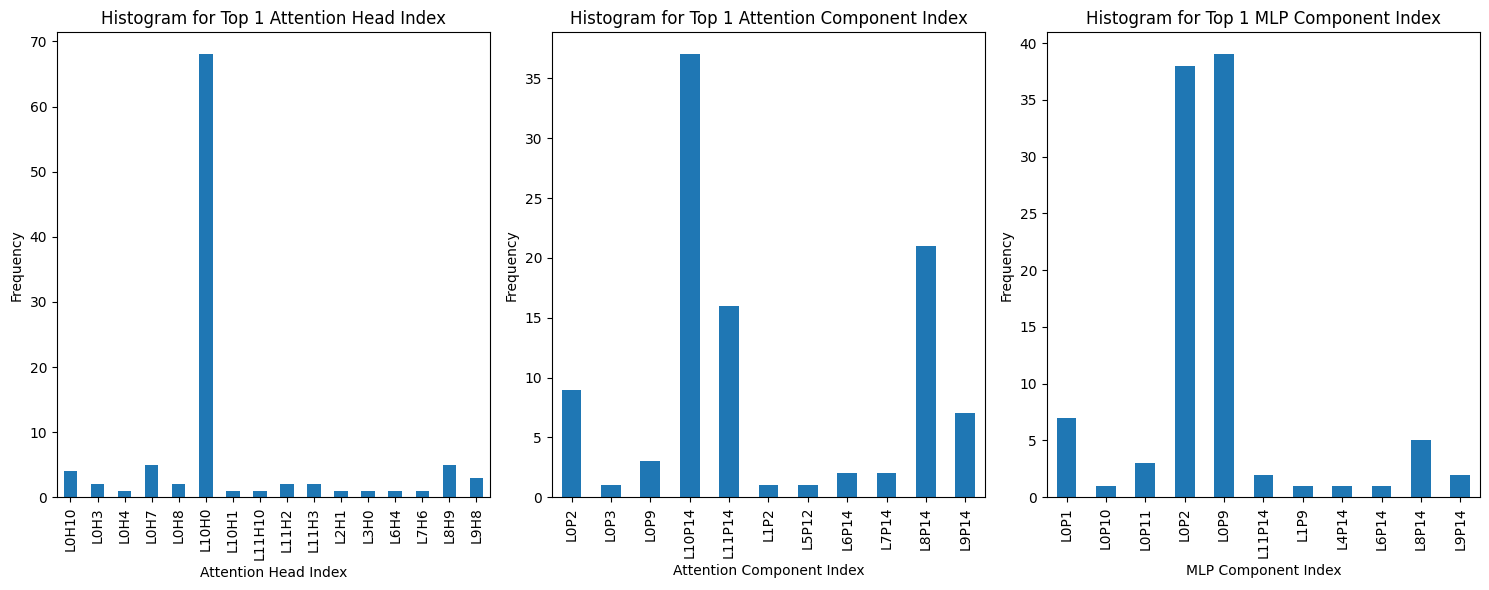

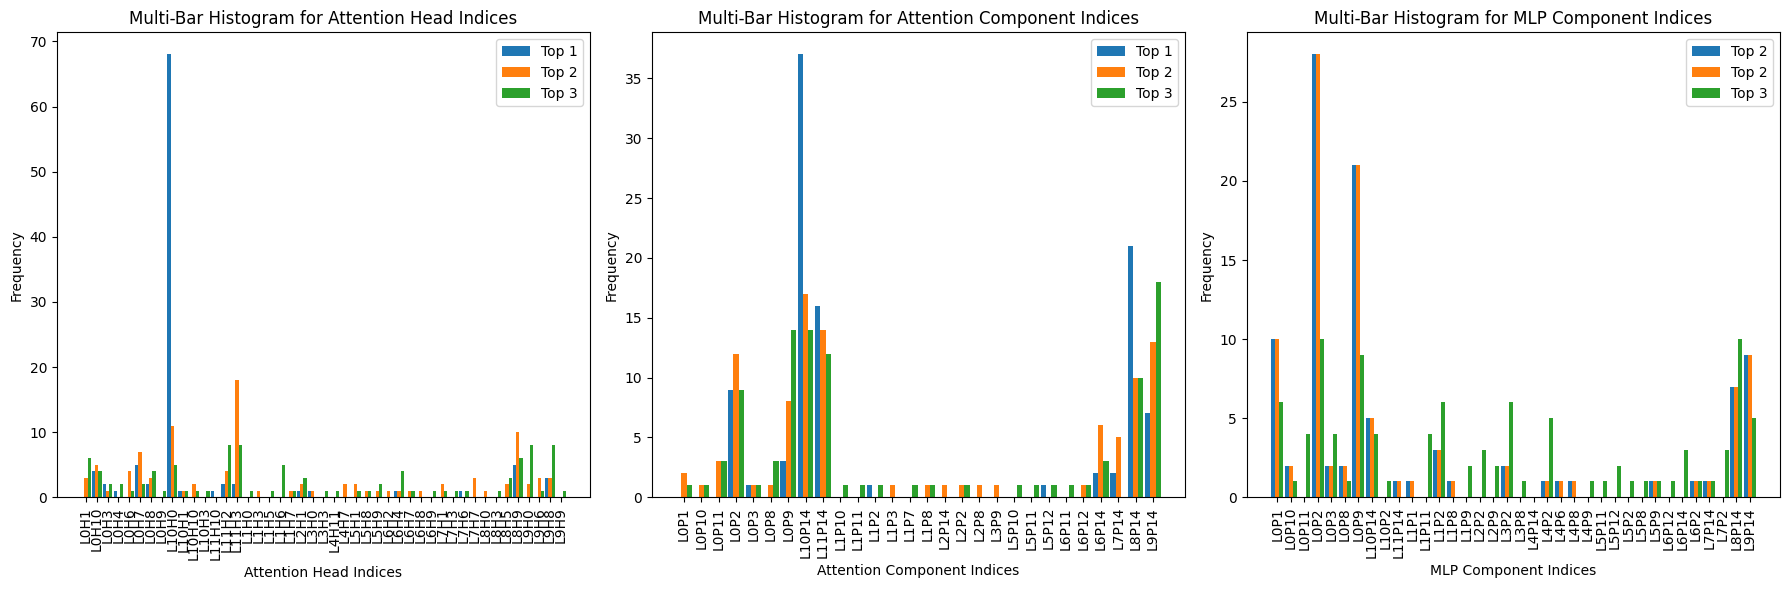

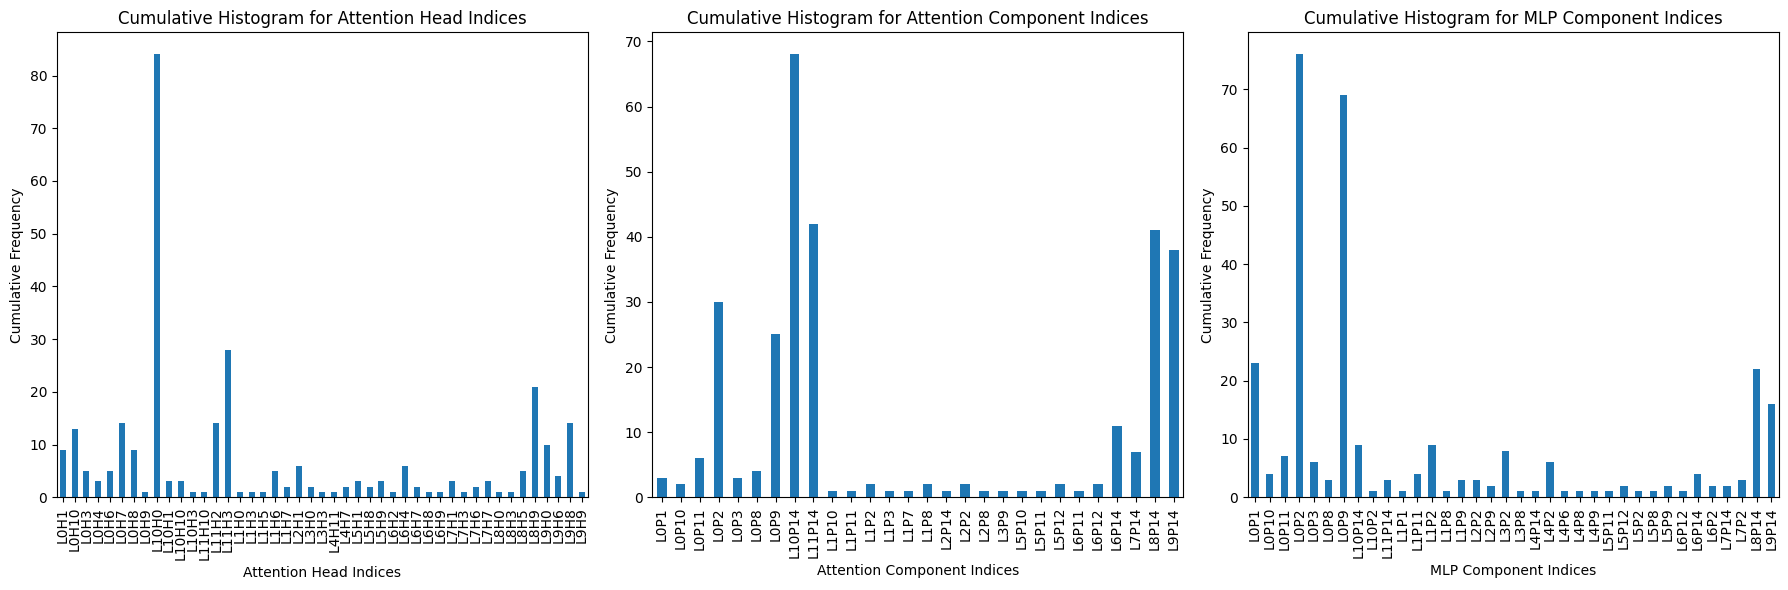

In [115]:
df = pd.read_csv("../results/locate_mechanism/gpt2_full_result_mem_top_component_per_prompt.csv")

import matplotlib.pyplot as plt

# Create histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Histogram for top1_attention_head_idx
df['top1_attention_head_idx'].value_counts().sort_index().plot(kind='bar', ax=axes[0])
axes[0].set_title('Histogram for Top 1 Attention Head Index')
axes[0].set_xlabel('Attention Head Index')
axes[0].set_ylabel('Frequency')

df["top1_component_attn_idx"].value_counts().sort_index().plot(kind='bar', ax=axes[1])
axes[1].set_title('Histogram for Top 1 Attention Component Index')
axes[1].set_xlabel('Attention Component Index')
axes[1].set_ylabel('Frequency')

# Histogram for top1_component_mlp_idx
df['top1_component_mlp_idx'].value_counts().sort_index().plot(kind='bar', ax=axes[2])
axes[2].set_title('Histogram for Top 1 MLP Component Index')
axes[2].set_xlabel('MLP Component Index')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Combine the top 3 indices for attention heads and MLP components
top3_attention_head_indices = pd.concat([df['top1_attention_head_idx'], df['top2_attention_head_idx'], df['top3_attention_head_idx']], axis=0).reset_index(drop=True)
top3_attn_out_indices = pd.concat([df['top1_component_attn_idx'], df['top2_component_attn_idx'], df['top3_component_attn_idx']], axis=0).reset_index(drop=True)
top3_mlp_indices = pd.concat([df['top1_component_mlp_idx'], df['top2_component_mlp_idx'], df['top3_component_mlp_idx']], axis=0).reset_index(drop=True)


# Count the frequencies
attention_head_counts = top3_attention_head_indices.value_counts().sort_index()
attn_out_count = top3_attn_out_indices.value_counts().sort_index()
mlp_counts = top3_mlp_indices.value_counts().sort_index()

# Prepare data for multi-bar histograms
labels = np.unique(top3_attention_head_indices)
top1_attention_counts = df['top1_attention_head_idx'].value_counts().reindex(labels, fill_value=0)
top2_attention_counts = df['top2_attention_head_idx'].value_counts().reindex(labels, fill_value=0)
top3_attention_counts = df['top3_attention_head_idx'].value_counts().reindex(labels, fill_value=0)

labels_attn = np.unique(top3_attn_out_indices)
top1_attn_counts = df['top1_component_attn_idx'].value_counts().reindex(labels_attn, fill_value=0)
top2_attn_counts = df['top2_component_attn_idx'].value_counts().reindex(labels_attn, fill_value=0)
top3_attn_counts = df['top3_component_attn_idx'].value_counts().reindex(labels_attn, fill_value=0)

labels_mlp = np.unique(top3_mlp_indices)
top1_mlp_counts = df['top1_component_mlp_idx'].value_counts().reindex(labels_mlp, fill_value=0)
top2_mlp_counts = df['top2_component_mlp_idx'].value_counts().reindex(labels_mlp, fill_value=0)
top3_mlp_counts = df['top3_component_mlp_idx'].value_counts().reindex(labels_mlp, fill_value=0)

# Create multi-bar histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Attention heads
x = np.arange(len(labels))
width = 0.3
axes[0].bar(x - width, top1_attention_counts, width, label='Top 1')
axes[0].bar(x, top2_attention_counts, width, label='Top 2')
axes[0].bar(x + width, top3_attention_counts, width, label='Top 3')
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels, rotation=90)
axes[0].set_title('Multi-Bar Histogram for Attention Head Indices')
axes[0].set_xlabel('Attention Head Indices')
axes[0].set_ylabel('Frequency')
axes[0].legend()

x_attn = np.arange(len(labels_attn))
axes[1].bar(x_attn - width, top1_attn_counts, width, label='Top 1')
axes[1].bar(x_attn, top2_attn_counts, width, label='Top 2')
axes[1].bar(x_attn + width, top3_attn_counts, width, label='Top 3')
axes[1].set_xticks(x_attn)
axes[1].set_xticklabels(labels_attn, rotation=90)
axes[1].set_title('Multi-Bar Histogram for Attention Component Indices')
axes[1].set_xlabel('Attention Component Indices')
axes[1].set_ylabel('Frequency')
axes[1].legend()


# MLP components
x_mlp = np.arange(len(labels_mlp))
axes[2].bar(x_mlp - width, top2_mlp_counts, width, label='Top 2')
axes[2].bar(x_mlp, top2_mlp_counts, width, label='Top 2')
axes[2].bar(x_mlp + width, top3_mlp_counts, width, label='Top 3')
axes[2].set_xticks(x_mlp)
axes[2].set_xticklabels(labels_mlp, rotation=90)
axes[2].set_title('Multi-Bar Histogram for MLP Component Indices')
axes[2].set_xlabel('MLP Component Indices')
axes[2].set_ylabel('Frequency')
axes[2].legend()

plt.tight_layout()
plt.show()

# Calculate cumulative counts for attention head indices and MLP component indices
cumulative_attention_counts = top1_attention_counts + top2_attention_counts + top3_attention_counts
cumulative_attn_out_counts = top1_attn_counts + top2_attn_counts + top3_attn_counts
cumulative_mlp_counts = top1_mlp_counts + top2_mlp_counts + top3_mlp_counts

# Create cumulative histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Cumulative histogram for attention head indices
cumulative_attention_counts.sort_index().plot(kind='bar', ax=axes[0])
axes[0].set_title('Cumulative Histogram for Attention Head Indices')
axes[0].set_xlabel('Attention Head Indices')
axes[0].set_ylabel('Cumulative Frequency')

cumulative_attn_out_counts.sort_index().plot(kind='bar', ax=axes[1])
axes[1].set_title('Cumulative Histogram for Attention Component Indices')
axes[1].set_xlabel('Attention Component Indices')
axes[1].set_ylabel('Cumulative Frequency')

# Cumulative histogram for MLP component indices
cumulative_mlp_counts.sort_index().plot(kind='bar', ax=axes[2])
axes[2].set_title('Cumulative Histogram for MLP Component Indices')
axes[2].set_xlabel('MLP Component Indices')
axes[2].set_ylabel('Cumulative Frequency')

plt.tight_layout()
plt.show()

